In [5]:
from pathlib import Path
from dotenv import load_dotenv
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import glob
import os

load_dotenv("../.env")

True

In [6]:
# FixMe: This is a strange way of loading this `.csv` file
protons_df = [pd.read_csv(path) for path in glob.glob("../data/csv/protons_2024*.csv")][0]
protons_df['time'] = pd.to_datetime(protons_df['time'])
protons_df

,time,bin,value
0,2023-09-01 00:00:56,1,6
1,2023-09-01 00:00:56,2,222
2,2023-09-01 00:00:56,3,27
3,2023-09-01 00:00:56,4,21
4,2023-09-01 00:00:56,5,18
...,...,...,...
3209548,2024-05-07 15:36:46,4,25
3209549,2024-05-07 15:36:46,5,19
3209550,2024-05-07 15:36:46,6,29
3209551,2024-05-07 15:36:46,7,25


In [7]:
protons_bin_1 = protons_df[protons_df['bin'] == 1]
protons_bin_1.drop('bin', axis=1)

,time,value
0,2023-09-01 00:00:56,6
16,2023-09-01 00:01:56,9
25,2023-09-01 00:02:56,4
35,2023-09-01 00:03:56,4
43,2023-09-01 00:04:56,7
...,...,...
3209515,2024-05-07 15:32:46,3
3209524,2024-05-07 15:33:46,2
3209533,2024-05-07 15:34:46,6
3209542,2024-05-07 15:35:46,5


## Compute background radiation mean and deviation

In [8]:
background_start, background_end = datetime.datetime(2024, 3, 21), datetime.datetime(2024, 3, 22)
noise_df = protons_bin_1[(protons_bin_1['time'] >= background_start) & (protons_bin_1['time'] <= background_end)]
noise_df

,time,bin,value
2592151,2024-03-21 00:00:06,1,4
2592160,2024-03-21 00:01:06,1,4
2592169,2024-03-21 00:02:06,1,8
2592179,2024-03-21 00:03:06,1,4
2592187,2024-03-21 00:04:06,1,5
...,...,...,...
2605067,2024-03-21 23:55:08,1,3
2605075,2024-03-21 23:56:08,1,6
2605084,2024-03-21 23:57:08,1,2
2605093,2024-03-21 23:58:08,1,2


In [9]:
noise_mean, noise_sigma = noise_df['value'].mean(), noise_df['value'].std()
print(f"Mean: {noise_mean:.2f}, Standard deviation: {noise_sigma:.2f}")

Mean: 4.96, Standard deviation: 2.29


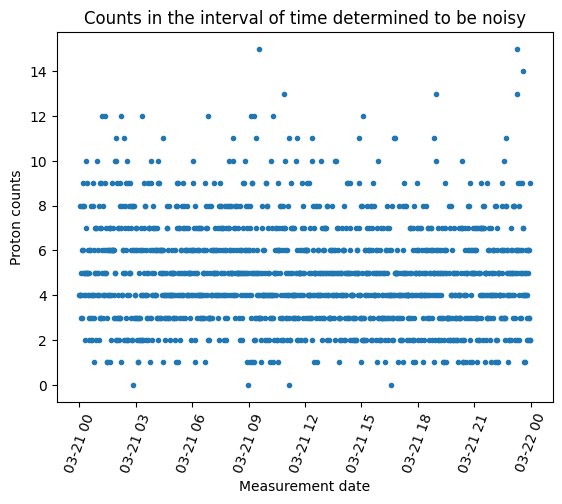

In [10]:
plt.scatter(x=noise_df['time'], y=noise_df['value'], marker='.')
plt.xlabel("Measurement date")
plt.ylabel("Proton counts")
plt.title("Counts in the interval of time determined to be noisy")
plt.xticks(rotation=70) # To rotate the dates by 70 degrees
plt.show()

## Determine search space

In [11]:
search_start, search_end = datetime.datetime(2024, 3, 23), datetime.datetime(2024, 3, 27)
search_df = protons_bin_1[(protons_bin_1['time'] >= search_start) & (protons_bin_1['time'] <= search_end)]
search_df.reset_index(drop=True, inplace=True) # This is to ensure that the indices from the main df are not retained

In [12]:
search_df

,time,bin,value
0,2024-03-23 00:00:10,1,8
1,2024-03-23 00:01:10,1,5
2,2024-03-23 00:02:10,1,8
3,2024-03-23 00:03:10,1,7
4,2024-03-23 00:04:10,1,4
...,...,...,...
5755,2024-03-26 23:55:17,1,22
5756,2024-03-26 23:56:17,1,33
5757,2024-03-26 23:57:17,1,27
5758,2024-03-26 23:58:17,1,25


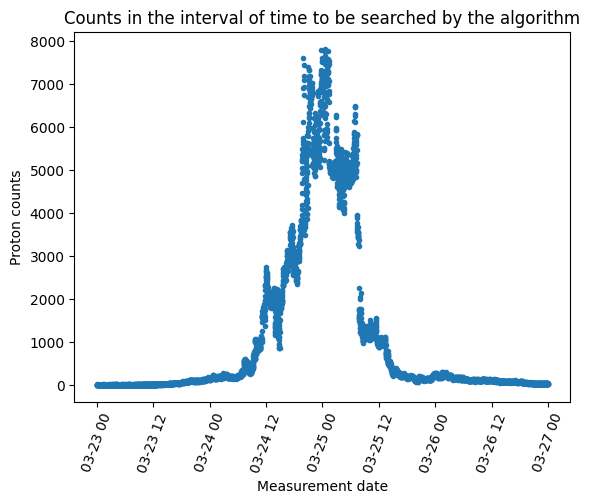

In [13]:
plt.scatter(x=search_df['time'], y=search_df['value'], marker='.')
plt.xlabel("Measurement date")
plt.ylabel("Proton counts")
plt.title("Counts in the interval of time to be searched by the algorithm")
plt.xticks(rotation=70) # To rotate the dates by 70 degrees
plt.show()

## Detection algorithm

In [14]:
# TODO: Rewrite with validation and more types. For example a pd.Series instead of pd.DataFrame
# TODO: Different naming for `sigma`, `cusum_window` and `channel`
def find_onset(series: pd.Series, background_mu_sigma: Tuple[float, float], cusum_window:int=30):
    # TODO: Parametrize outside of function
    sigma_multiplier = 2
    bg_mean, bg_sigma = background_mu_sigma
    uncertainty_limit = bg_mean + sigma_multiplier * bg_sigma

    # FixMe: Floating point comparison
    if bg_mean == uncertainty_limit:
        raise ValueError("""Background radiation mean value and uncertainty limit are equal.
                            Control parameter k cannot be computed.""")

    k = (uncertainty_limit - bg_mean) / (np.log1p(uncertainty_limit) - np.log1p(bg_mean))
    hastiness = 1 if k < 1.0 else 2

    alert = 0
    previous_cusum, cusum = 0, 0

    onset_time = None
    for i in range(1, len(series)):
        normalized_flux = (series.iloc[i] - bg_mean) / bg_sigma
        previous_cusum, cusum = cusum, max(0, normalized_flux - round(k) + previous_cusum)
        alert = alert + 1 if cusum > hastiness else 0

        if alert == cusum_window:
            onset_time = series.index[i - alert]
            break
        
    return onset_time

## Computing SEP onset times in search interval

In [15]:
onset_index = find_onset(series=search_df['value'], background_mu_sigma=(noise_mean, noise_sigma), cusum_window=30)
onset_data = search_df.iloc[onset_index]
print(f"Found onset: {onset_data['time']}")

Found onset: 2024-03-23 15:01:11


In [16]:
peak_data = search_df.loc[search_df['value'].idxmax()]
print(f"Found peak: {peak_data['time']}")

Found peak: 2024-03-25 00:37:14


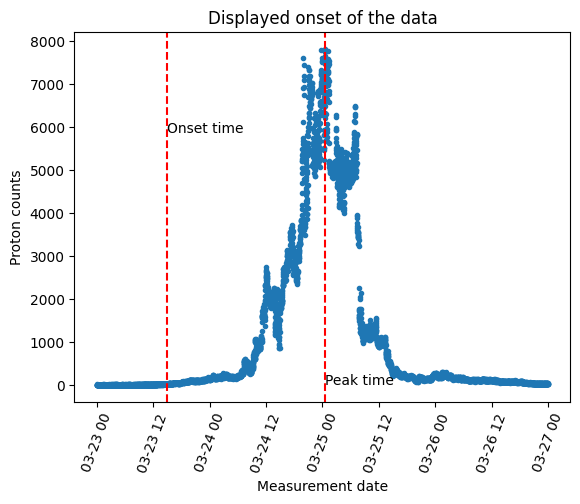

In [17]:
plt.scatter(x=search_df['time'], y=search_df['value'], marker='.')
plt.xlabel("Measurement date")
plt.ylabel("Proton counts")
plt.title("Displayed onset of the data")

# Display and annotate the onset time
plt.axvline(x=onset_data['time'], color='r', linestyle='--')
plt.annotate('Onset time', xy=(onset_data['time'], search_df.max()['value'] * 3/4))

# Display and annotate peak time
plt.axvline(x=peak_data['time'], color='r', linestyle='--')
plt.annotate('Peak time', xy=(peak_data['time'], 0))

plt.xticks(rotation=70) # To rotate the dates by 70 degrees
plt.show()

## Dispaly the entire interval with noise included

In [30]:
full_df = protons_bin_1[(protons_bin_1['time'] >= background_start) & (protons_bin_1['time'] <= search_end)]

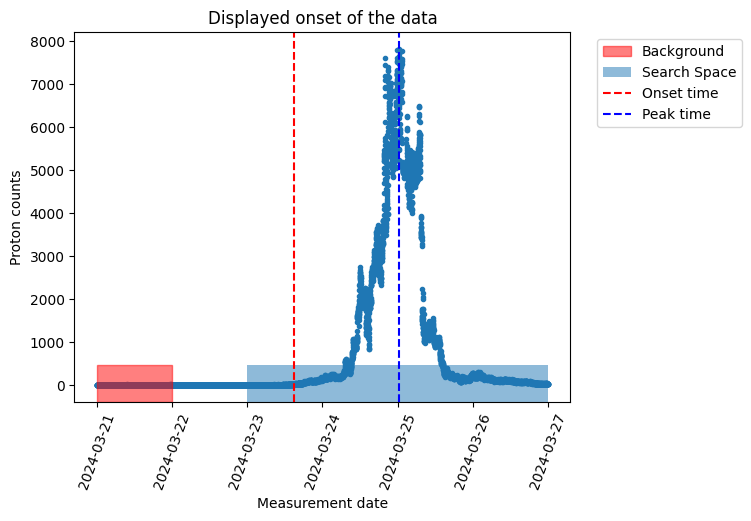

In [31]:
plt.scatter(x=full_df['time'], y=full_df['value'], marker='.')
plt.xlabel("Measurement date")
plt.ylabel("Proton counts")
plt.title("Displayed onset of the data")

# Display background range
plt.axvspan(background_start, background_end, ymax=0.1, color='r', label="Background", alpha=0.5)

# Display search space
plt.axvspan(search_start, search_end, ymax=0.1, label="Search Space", alpha=0.5)

# Display and annotate the onset time
plt.axvline(x=onset_data['time'], color='r', linestyle='--', label="Onset time")
# plt.annotate('Onset time', xy=(onset_data['time'], search_df.max()['value'] * 3/4))

# Display and annotate peak time
plt.axvline(x=peak_data['time'], color='b', linestyle='--', label="Peak time")
# plt.annotate('Peak time', xy=(peak_data['time'], 0))

plt.xticks(rotation=70) # To rotate the dates by 70 degrees
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.))
plt.show()

## All components connected into one funciton

In [35]:
def onset_stats(data, bin, noise_interval, search_interval):
    background_start, background_end = noise_interval
    search_start, search_end = search_interval
    
    df_channel = data[data['bin'] == bin]
    df_channel.drop('bin', axis=1)

    # Compute the noise
    noise_df = df_channel[(df_channel['time'] >= background_start) & (df_channel['time'] <= background_end)]
    noise_mean, noise_sigma = noise_df['value'].mean(), noise_df['value'].std()
    print(f"Mean: {noise_mean:.2f}, Standard deviation: {noise_sigma:.2f}")

    # Filter search interval
    search_df = df_channel[(df_channel['time'] >= search_start) & (df_channel['time'] <= search_end)]
    search_df.reset_index(drop=True, inplace=True) # This is to ensure that the indices from the main df are not retained

    # Compute onset
    onset_index = find_onset(series=search_df['value'], background_mu_sigma=(noise_mean, noise_sigma), cusum_window=30)
    onset_data = search_df.iloc[onset_index]
    print(f"Found onset: {onset_data['time']}")

    # Compute peak
    peak_data = search_df.loc[search_df['value'].idxmax()]
    print(f"Found peak: {peak_data['time']}")

    # Plot onset and peak
    full_df = df_channel[(df_channel['time'] >= background_start) & (df_channel['time'] <= search_end)]
    plt.clf()
    plt.scatter(x=full_df['time'], y=full_df['value'], marker='.')
    plt.xlabel("Measurement date")
    plt.ylabel("Proton counts")
    plt.title("Displayed onset of the data")

    # Display background range
    plt.axvspan(background_start, background_end, ymax=0.1, color='r', label="Background", alpha=0.5)

    # Display search space
    plt.axvspan(search_start, search_end, ymax=0.1, label="Search Space", alpha=0.5)

    # Display and annotate the onset time
    plt.axvline(x=onset_data['time'], color='r', linestyle='--', label="Onset time")
    # plt.annotate('Onset time', xy=(onset_data['time'], search_df.max()['value'] * 3/4))

    # Display and annotate peak time
    plt.axvline(x=peak_data['time'], color='b', linestyle='--', label="Peak time")
    # plt.annotate('Peak time', xy=(peak_data['time'], 0))

    plt.xticks(rotation=70) # To rotate the dates by 70 degrees
    plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.))
    plt.show()

Mean: 4.96, Standard deviation: 2.29
Found onset: 2024-03-23 15:01:11
Found peak: 2024-03-25 00:37:14


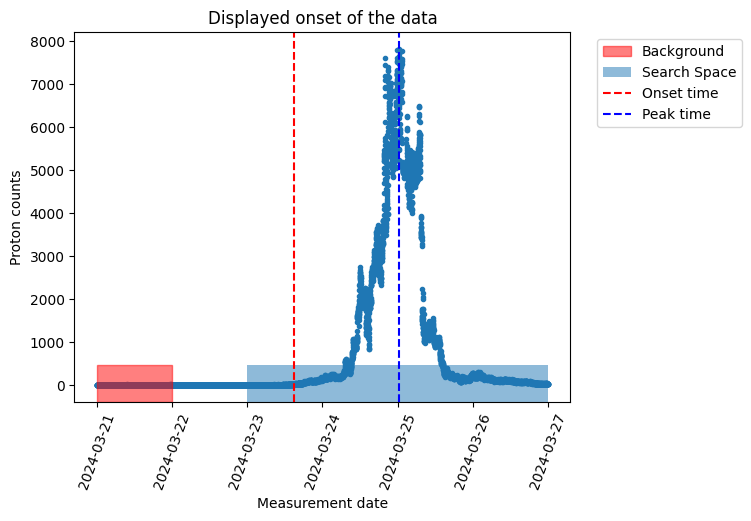

In [41]:
background_start, background_end = datetime.datetime(2024, 3, 21), datetime.datetime(2024, 3, 22)
search_start, search_end = datetime.datetime(2024, 3, 23), datetime.datetime(2024, 3, 27)

onset_stats(data=protons_df,
            bin=1,
            noise_interval=(background_start, background_end),
            search_interval=(search_start, search_end))